# Testing RetinaNet Inference with SageMaker Endpoint
## Import Libraries

In [1]:
# show images inline
%matplotlib inline

# import keras_retinanet
from keras_retinanet import models
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color

# import miscellaneous modules
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import time
import keras
import boto3
import sagemaker
import h5py
import json

# Configure SageMaker
sagemaker_client = boto3.client('sagemaker')
role = sagemaker.get_execution_role()

# enter model prefix
#model_prefix = '<CloudFormation Model Prefix>'
model_prefix = 'haas-sagemaker'

Using TensorFlow backend.


## Load Image

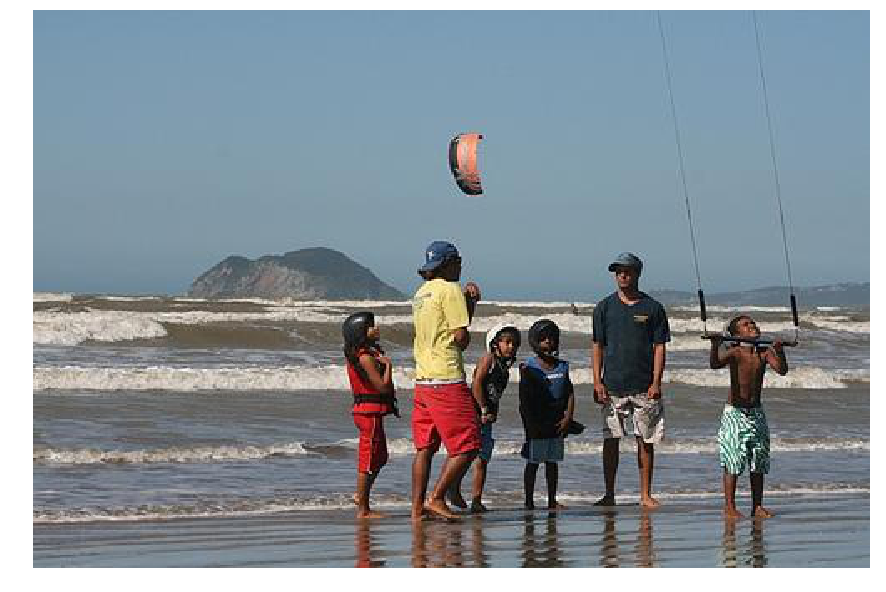

In [2]:
# load image
image = read_image_bgr('/home/ec2-user/SageMaker/tmp/images/10.jpg')

# Labels
labels_to_names = {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted plant', 59: 'bed', 60: 'dining table', 61: 'toilet', 62: 'tv', 63: 'laptop', 64: 'mouse', 65: 'remote', 66: 'keyboard', 67: 'cell phone', 68: 'microwave', 69: 'oven', 70: 'toaster', 71: 'sink', 72: 'refrigerator', 73: 'book', 74: 'clock', 75: 'vase', 76: 'scissors', 77: 'teddy bear', 78: 'hair drier', 79: 'toothbrush'}

# sample image
draw = image.copy()
draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(15, 15))
plt.axis('off')
plt.imshow(draw)
plt.show()

## Create Payload

In [3]:
# preprocess image for inference
image = preprocess_image(image)
image, scale = resize_image(image)

# create inference request payload
endpoint_name = sagemaker_client.describe_endpoint(EndpointName=model_prefix)['EndpointName']
request_payload = json.dumps(image.tolist())

## Invoke Endpoint

In [5]:
runtime_client = boto3.client('sagemaker-runtime')
prediction = json.loads(
    runtime_client.invoke_endpoint(
        EndpointName=endpoint_name,
        ContentType='application/json',
        Body=request_payload
    )
)

ConnectionClosedError: Connection was closed before we received a valid response from endpoint URL: "https://runtime.sagemaker.us-west-2.amazonaws.com/endpoints/haas-sagemaker/invocations".

## Format Response

In [ ]:
# parse reponse
boxes = np.array(prediction['boxes'])
boxes /= scale
scores = np.array(prediction['scores'])
labels = np.array(prediction['labels'])

## View Prediction Results

In [ ]:
# visualize detections
for box, score, label in zip(boxes[0], scores[0], labels[0]):
    # scores are sorted so we can break
    if score < 0.5:
        break
        
    color = label_color(label)
    
    b = box.astype(int)
    draw_box(draw, b, color=color)
    
    caption = "{} {:.3f}".format(labels_to_names[label], score)
    draw_caption(draw, b, caption)

# final image
plt.imshow(draw)
plt.show()